# 1. Import Depedencies

In [1]:
# Install Depedencies
!pip -q install hpelm

# Import Depedencies
import os
import warnings
import numpy as np
import tensorflow as tf
import seaborn as sns
import random
import pandas as pd
import cv2
from hpelm import ELM
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
warnings.filterwarnings("ignore")

# 2. Data Preparation

In [2]:
# create dataframe from file path
dataset_path = "../input/utkface-new/UTKFace" 
images = np.array([])
ages = np.array([])

for filename in os.listdir(dataset_path):
    ages = np.append(ages, filename.split('_')[0])
    images = np.append(images, f"../input/utkface-new/UTKFace/{filename}")
    
images = pd.Series(images, name = "Name")
ages = pd.Series(ages, name ="Age", dtype = 'int')
df = pd.concat([images,ages], axis = 1)
df.head()

,Name,Age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17


In [3]:
# Classifying Age Into Several Groups (Adiance Dataset Group)
def ages_group(age):
    
    if(0 <= age <= 2):
        return "0 - 2"
    elif(4 <= age <= 6):
        return "4 - 6"
    elif(8 <= age <= 13):
        return "8 - 13"
    elif(15 <= age <= 20):
        return "15 - 20"
    elif(25 <= age <= 32):
        return "25 - 32"
    elif(38 <= age <= 43):
        return "38 - 43"
    elif(48 <= age <= 53):
        return "48 - 53"
    elif(age >= 60):
        return "60++"
    else:
        return "no group"
    
ages_group = pd.Series(df['Age'].apply(ages_group), name = "Group")
df_group = pd.concat([df, ages_group], axis = 1)
df_group = df_group[df_group["Group"] != 'no group'].reset_index(drop = True)
df_group.head()

,Name,Age,Group
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,25 - 32
1,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,25 - 32
2,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,15 - 20
3,../input/utkface-new/UTKFace/76_0_0_2017010421...,76,60++
4,../input/utkface-new/UTKFace/18_1_0_2017010402...,18,15 - 20


# 3. Predicting Images with CNN ELM

In [81]:
def get_model(model_path):
    cnn_layer =  tf.keras.models.load_model(model_path + '/feature_extractor.h5')
    classifier = ELM(inputs = cnn_layer.output.shape[-1], outputs = 8)
    classifier.load(f'{model_path}/elm_classifier.pkl')
    
    return cnn_layer, classifier

def predict(input, cnn_layer, classfier):
    # Extract Features
    features = np.array(cnn_layer(input)) 

    # predict with ELM
    pred = classfier.predict(features)
    
    return pred

def get_age_label(input):
    classes = {
        0 : "0 - 2",
        1 : "4 - 6",
        2 : "8 - 13",
        3 : "15 - 20",
        4 : "25 - 32",
        5 : "38 - 43",
        6 : "48 - 53",
        7 : "60++"
    }
    return classes[np.argmax(input)]

def predict_sample(cnn_layer, classfier, samples):
    plt.figure(figsize = (15, 7))
    plot = 0
    for i in samples:
        img = mpimg.imread(df_group.iloc[i]['Name'])
        img = cv2.resize(img, (224,224)) / 255.
        pred = predict(np.expand_dims(img, axis = 0), cnn_layer, classfier)
        pred = get_age_label(pred)
        label = df_group.iloc[i]['Group']
        plot += 1
        plt.subplot(2, 5, plot) 
        plt.imshow(img)
        plt.title(f"Predicted {pred} Years Old", c = 'red' if pred != label else 'black')
        plt.xlabel(f"Actual is {label} Years Old",fontsize =12)
        plt.xticks([])
        plt.yticks([])

    plt.show()

In [60]:
# ResNet50 (imgnet)
resnet50_imgnet, resnet50_imgnet_classfier = get_model('../input/cnnelmandcnnbpmodel/CNN ELM Model/ResNet50+imgnet+ELM')

# ResNet50 (vggface)
resnet50_vggface, resnet50_vggface_classfier = get_model('../input/cnnelmandcnnbpmodel/CNN ELM Model/ResNet50+vggface+ELM')

# VGG16 (imgnet)
vgg16_imgnet, vgg16_imgnet_classfier = get_model('../input/cnnelmandcnnbpmodel/CNN ELM Model/Vgg16+imgnet+ELM')

# VGG16(vggface)
vgg16_vggface, vgg16_vggface_classfier = get_model('../input/cnnelmandcnnbpmodel/CNN ELM Model/Vgg16+vggface+ELM')

In [74]:
# Random id sample
rand_idx = np.random.randint(low = 0, high = len(df_group), size=10)
print(rand_idx)

[10205, 12104, 16478, 12828, 10050, 12290, 9937, 6768, 12123, 15376]


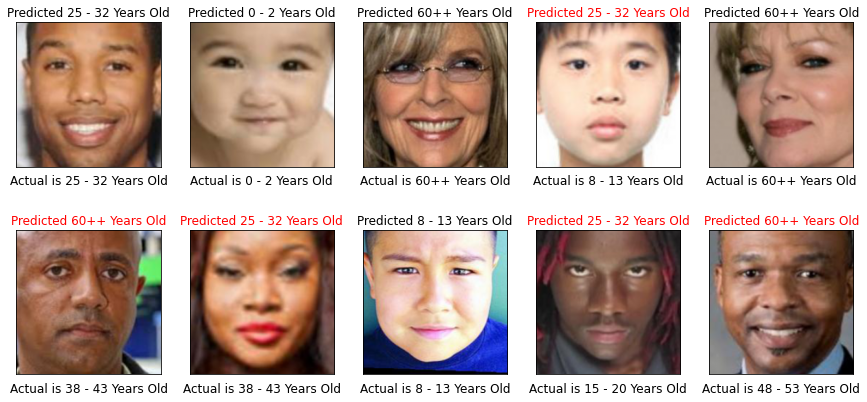

In [82]:
# Predict with ResNet50 (imgnet)
predict_sample(resnet50_imgnet, resnet50_imgnet_classfier, rand_idx)

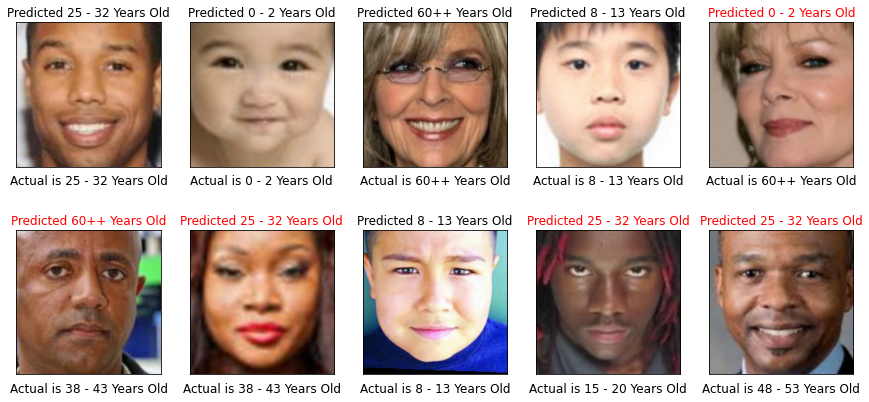

In [83]:
# Predict with ResNet50(vggface)
predict_sample(resnet50_vggface, resnet50_vggface_classfier, rand_idx)

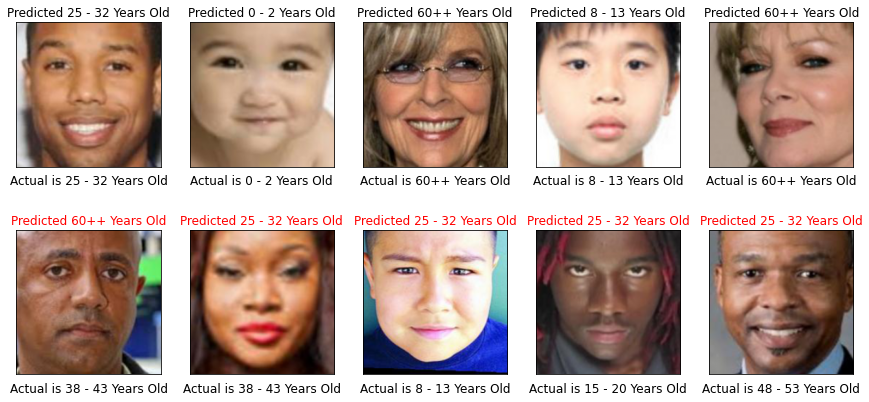

In [84]:
# Predict with VGG16(imgnet)
predict_sample(vgg16_imgnet, vgg16_imgnet_classfier , rand_idx)

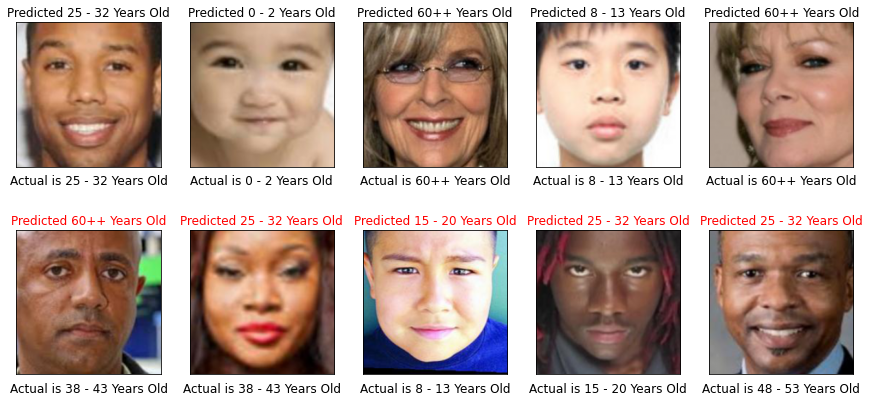

In [85]:
# Predict with VGG16(vggface)
predict_sample(vgg16_vggface, vgg16_vggface_classfier, rand_idx)

# 4. Predicting Images with CNN BP

In [86]:
def get_model(model_path): 
    cnn =  tf.keras.models.load_model(model_path)
    return cnn

def predict_sample(cnn_model, samples):
    plt.figure(figsize = (15, 38))
    plot = 0
    for i in samples:
        img = mpimg.imread(df_group.iloc[i]['Name'])
        img = cv2.resize(img, (224,224)) / 255.
        pred = cnn_model.predict(np.expand_dims(img, axis = 0))
        pred = get_age_label(pred)
        label = df_group.iloc[i]['Group']
        plot += 1
        plt.subplot(10, 5, plot) 
        plt.imshow(img)
        plt.title(f"Predicted {pred} Years Old", c = 'red' if pred != label else 'black')
        plt.xlabel(f"Actual is {label} Years Old",fontsize =12)
        plt.xticks([])
        plt.yticks([])

    plt.show()

resnet50_imgnet_bp = get_model('../input/cnnelmandcnnbpmodel/CNN BP Model/resnet50_imgnet_bp.h5')
resnet50_vggface_bp = get_model('../input/cnnelmandcnnbpmodel/CNN BP Model/resnet50_vggface_bp.h5')
vgg16_imgnet_bp = get_model('../input/cnnelmandcnnbpmodel/CNN BP Model/vgg16_imgnet_bp.h5')
vgg16_vggface_bp = get_model('../input/cnnelmandcnnbpmodel/CNN BP Model/vgg16_vggface_bp.h5')

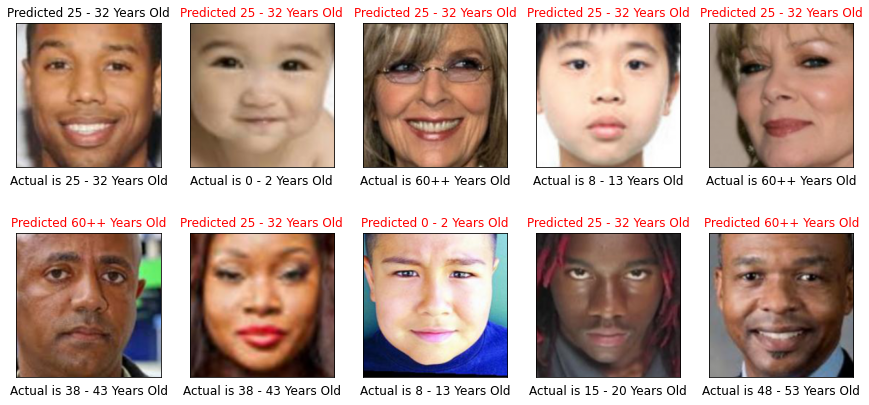

In [87]:
# Predict with ResNet50 (imgnet)
predict_sample(resnet50_imgnet_bp, rand_idx)

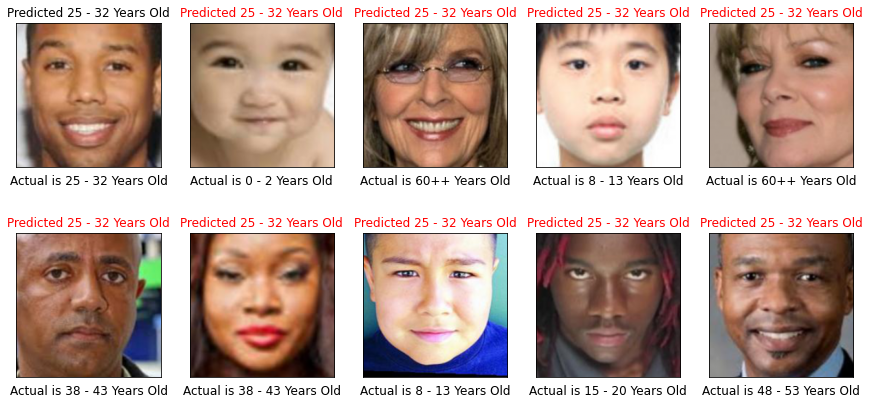

In [88]:
# Predict with ResNet50 (vggface)
predict_sample(resnet50_vggface_bp, rand_idx)

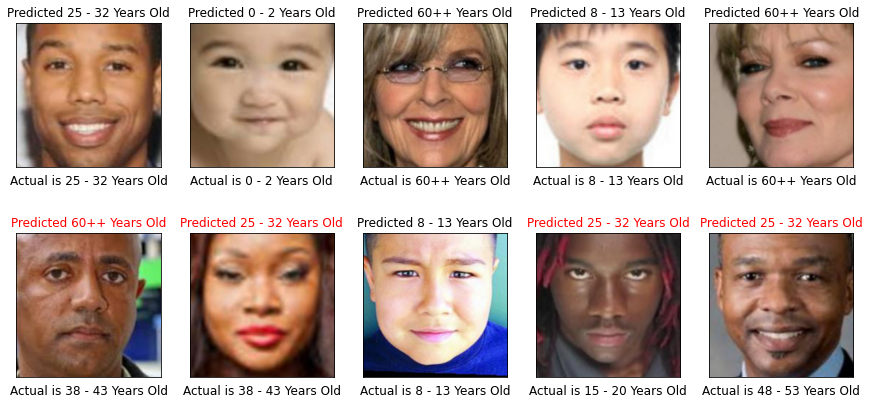

In [89]:
# Predict with vgg16 (imgnet)
predict_sample(vgg16_imgnet_bp, rand_idx)

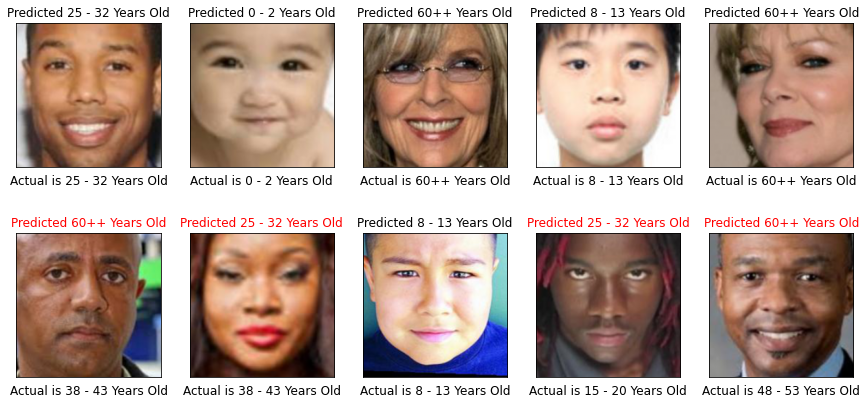

In [90]:
# Predict with vgg16 (vggface)
predict_sample(vgg16_vggface_bp, rand_idx)